In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vector
import pandas as pd
import lhapdf
import itertools

## General code for calculating polarization vector

In [2]:
# Tau mass
mtau = 1.77682 # GeV

def polarization_vector(tau4m, nu4m, nucleon4m, int_type: str):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m) # TODO check that this is the angle that I expect
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    # I might also pass this as a parameter. Though probably not, since the model assumes that it is a nucleon, not a nucleus.
    Q2 = -q**2
    assert np.all(Q2 > 0), Q2

    W2 = (p + q)**2
    assert np.all(W2 > 0), W2
    
    x = Q2 / (2*p.dot(q)) # Björken scaling variable
    
    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    elif int_type == "res":
        raise NotImplementedError("Resonance scattering not implemented")
    elif int_type == "dis":
        W1 = W1dis(x, Q2, p, q, M)
        W2 = W2dis(x, Q2, p, q, M)
        W3 = W3dis(x, Q2, p, q, M)
        W4 = W4dis(x, Q2, p, q, M)
        W5 = W5dis(x, Q2, p, q, M)
    else:
        raise ValueError(f"Unsupported interaction type {int_type = }")
    
    R = (
        (Etau - ptau * costheta) / M * (W1 + mtau / (2*M**2)*W4)
        + (Etau + ptau * costheta) / (2*M) * W2
        + ((Enu + Etau) / M * (Etau - ptau * costheta) / (2*M) - mtau**2 / (2*M**2)) * W3
        - mtau**2 / (2*M) * W5
    )

    return (
        # P_P component, in the tau-nu plane
        mtau * np.sin(theta) / (2*M*R) * (
            -(2*W1 - W2 - mtau**2/M**2 * W4 + Etau/M * W5) - Enu / M * W3 # X in lepton polarization paper, eq 7a
        ),
        # P_L component
        -1 + mtau**2/(M**2 * R) * (
            (2*M/(Etau + ptau) * W1 + (Etau - ptau) / (Etau + ptau) * W3) * np.cos(theta/2)**2
            + (M/(Etau + ptau) * W2 + (Etau + ptau) / M * W4 - W5) * np.sin(theta/2)**2
        ),
    )

In [39]:
# Cabbibo angle, from https://en.wikipedia.org/wiki/Cabibbo%E2%80%93Kobayashi%E2%80%93Maskawa_matrix
theta_c = 13.02 * np.pi/180 # radians
#
M_V = 0.84 # GeV
# difference between muon and electron magnetic moments (I think, see tau polarization paper)
xi = 3.706
# 
M_A = 1 # GeV
#
F_A_0 = -1.23
# Pion mass
m_pi = 0.139 # GeV


def w(p, q, M):
    return p.dot(q)/M**2

def G_V_E(q):
    return 1 / (1-q**2/M_V**2)**2

def G_V_M(q):
    return (1+xi) / (1-q**2/M_V**2)**2

def F_V(q, M):
    return (G_V_E(q) - q**2 / (4*M**2) * G_V_M(q)) / (1 - q**2 / (4*M**2))

def F_M(q, M):
    return (G_V_M(q) - G_V_M(q)) / (xi * (1 - q**2 / (4*M**2)))

def F_A(q):
    return F_A_0 / (1 - q**2 / M_A**2)**2

def F_T(q):
    return 0

def F_S(q):
    return 0

def F_p(q, M):
    return 2*M**2 * F_A(q) / (m_pi**2 - q**2)

def Wqel_coefficient(p, q, M):
    return np.cos(theta_c)**2 * 1/w(p, q, M) 

def W1qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (F_A(q)**2 + xprime * (F_A(q)**2 + (F_V(q, M) + F_M(q, M))**2))
    )

def omega_2(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return F_V(q, M)**2 + F_A(q)**2 + xprime * (F_M(q, M)**2 + 4*F_T(q)**2)

def W2qel(x, Q2, p, q, M):
    return (
        Wqel_coefficient(p, q, M)
        * omega_2(x, Q2, p, q, M)
    )

def W3qel(x, Q2, p, q, M):
    return (
        Wqel_coefficient(p, q, M)
        * -2 * np.real(np.conj(F_A(q)) * (F_V(q, M) + F_M(q, M)))
    )

def W4qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        # omega_4
        * (
            np.real(np.conj(F_V(q, M)) * (F_S(q) - 1/2 * F_M(q, M)) - np.conj(F_A(q)) * (F_T(q) + F_p(q, M)))
            + xprime * (1/2 * (F_M(q, M) - F_S(q))**2 + (F_T(q) + F_p(q, M))**2)
            - 1/4* (1+xprime) * F_M(q, M)**2 + (1+1/2 * xprime) * F_S(q)**2
        )
    )

def W5qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(p, q, M)
        * (
            2 * np.real(np.conj(F_S(q)) * (F_V(q, M) - xprime*F_M(q, M)) - np.conj(F_T(q)) * (F_A(q) - 2*xprime*F_p(q, M)))
            + omega_2(x, Q2, p, q, M)
        )
    )

In [41]:
particle_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_particles.csv")
event_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_event_info.csv")

In [42]:
qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
taus = qel_particles[qel_particles["pdg"] == 15]
nus = qel_particles.groupby("event_num").nth(1)
assert np.all(nus["pdg"] == 16)
nucleons = qel_particles.groupby("event_num").first()
assert np.all(nucleons["pdg"] > 1000)
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

In [43]:
nutaus = qel_particles.groupby("event_num").nth(1).reset_index(drop=True)
assert (nutaus["pdg"] == 16).all()
taus = qel_particles.groupby("event_num").nth(2).reset_index(drop=True)
assert (taus["pdg"] == 15).all()

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})
q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

# delta-function, where x must be 1. To get this, we adjust the mass of the nucleon
M = -q**2 / (2*q.E)
nucleon4m = vector.array({"E": M, "px": np.zeros(M.shape), "py": np.zeros(M.shape), "pz": np.zeros(M.shape)})
x = -q**2 / (2*nucleon4m.dot(q))
assert np.allclose(x, 1), x

In [44]:
zero_angle_tau_event = np.argmin(tau_angles)

s = np.array(polarization_vector(vector.MomentumNumpy4D(tau4m[zero_angle_tau_event]), vector.MomentumNumpy4D(nutau4m[zero_angle_tau_event]), vector.MomentumNumpy4D(nucleon4m[zero_angle_tau_event]), "qel"))

# The polarization (second term) should be slightly below 1 (center left panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be very close to -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

(array([[-0.00235612],
        [-0.96285849]]),
 0.9628613746358623,
 array([-0.99999701]))

In [45]:
# s = np.array(spin_vector(tau4m, nu4m, nucleon4m, "qel"))
# # The polarization (second term) should be slightly less than 1
# # See center left panel, figure 6 in tau polarization paper
# s, np.linalg.norm(s)*2

The values above are really good and close to what they should be. Let us now check $\theta = 5^\circ, 10^\circ$, since these are reproduced in the paper as well.

In [46]:
almost5deg = np.abs(tau_angles * 180/np.pi - 5).argmin()
tau_angles.iloc[almost5deg] * 180/np.pi, taus.iloc[almost5deg]["E"]

(5.000498804220101, 9.420946604808174)

In [47]:
s = np.array(
    polarization_vector(
        vector.MomentumNumpy4D(tau4m[almost5deg]), 
        vector.MomentumNumpy4D(nutau4m[almost5deg]), 
        vector.MomentumNumpy4D(nucleon4m[almost5deg]),
        "qel"
    )
)

# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

(array([[-0.24444344],
        [-0.97038647]]),
 1.0007010065630684,
 array([-0.9697067]))

In [48]:
tau_deg = tau_angles * 180/np.pi 
# Select the event with the highest energy tau and a tau angle between 9.9 and 10.1 degrees
almost10deg = taus[((9.9 < tau_deg) & (tau_deg < 10.1)).values]["E"].idxmax()

s = np.array(
    polarization_vector(
        vector.MomentumNumpy4D(tau4m[almost10deg]), 
        vector.MomentumNumpy4D(nutau4m[almost10deg]), 
        vector.MomentumNumpy4D(nucleon4m[almost10deg]),
        "qel"
    )
)

# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

(array([[-0.35175066],
        [-0.95547395]]),
 1.0181645206187715,
 array([-0.93842785]))

In [49]:
taus.iloc[almost10deg, :]

event_num    8318.000000
pdg            15.000000
E               8.535322
px             -1.343307
py              0.506686
pz              8.223955
polx            0.060693
poly            0.160907
polz           -0.985102
Name: 1328, dtype: float64

There is something wrong with the code still. Here, the polarization value should be much higher and the angle should be closer to -1.

### Calculate polarization for all qel events

In [50]:
s = polarization_vector(
    tau4m, 
    nutau4m, 
    nucleon4m,
    "qel"
)

# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s, axis=0), s[1] / np.linalg.norm(s)

((array([-0.17636519, -0.16045718, -0.16980134, ..., -0.51469093,
         -0.15810976, -0.15757129]),
  array([-0.97810444, -0.97924092, -0.97723179, ..., -0.90019195,
         -0.97770253, -0.97925965])),
 array([0.99387775, 0.9923    , 0.99187422, ..., 1.03694373, 0.99040443,
        0.99185592]),
 array([-0.01180724, -0.01182096, -0.01179671, ..., -0.01086672,
        -0.01180239, -0.01182119]))

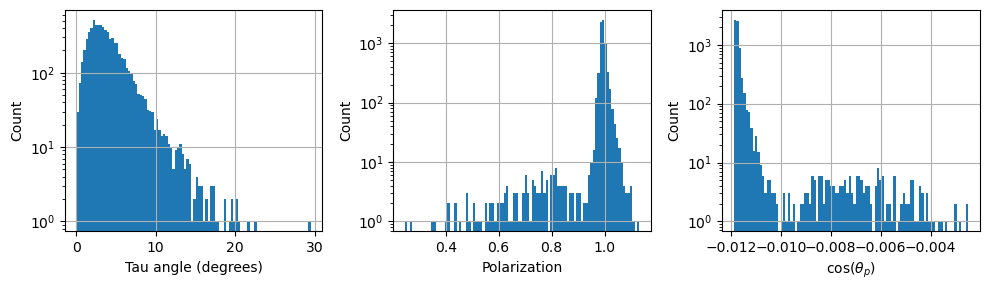

In [57]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3), layout="tight")
ax[0].hist(tau_angles * 180/np.pi, bins=100)
ax[0].set(xlabel="Tau angle (degrees)", ylabel="Count")

ax[1].hist(np.linalg.norm(s, axis=0), bins=100)
ax[1].set(xlabel="Polarization", ylabel="Count")

ax[2].hist(s[1] / np.linalg.norm(s), bins=100)
ax[2].set(xlabel=r"$\cos(\theta_p)$", ylabel="Count")

for a in ax:
    a.grid()
    a.set_yscale("log")

In some cases, I get a polarization vector that has magnitude > 1. Though this might not be completely incorrect, since the equations are not perfect and there might be some assumptions here and there that I break (e.g., they might always assume that the nucleon mass is 0.938 GeV, whereas that is not true and that is not the value that I pass to the code).
If $|s| > 1$, I can simply normalize the vector.

## Resonance scattering

In [ ]:
# Resonance scattering
# Delta mass
M_delta = 1.232 # GeV
# Delta width assuming dominance of S-waves
Gamma_delta = 0.12 # GeV
# Is 2 if the Delta produced is Delta++ (interaction with p), 
# and 2/3 if the Delta produced is Delta+ (interaction with n). 
# Maybe take average, since there are equally many n and p in Oxygen?
kappa = 2

def W1res(x, Q2, p, q, M):
    return (
        kappa * np.cos(theta_c)**2 * M * M_delta * 
        eta_delta_bw(W)**2 * 
        sum(
            V_1(x, Q2, j, k) * C_V(x, Q2, j) * C_V(x, Q2, k) 
            + A_1(x, Q2, j, k) * C_A(x, Q2, j) * C_A(x, Q2, k) 
            for j, k in itertools.product(range(3, 7), repeat=2)
        )
    )

## Deep inelastic scattering

In [110]:
# Deep inelastic scattering
# The PDFs used in GENIE seems to bee CT10nlo, member 0 from LHAPDF. Source: https://github.com/GENIE-MC/Generator/blob/master/config/LHAPDF6.xml
# I should therefore probably use the same here
def pdf(quark, x, Q2):
    p = lhapdf.mkPDF("CT10nlo", 0)
    return p.xfxQ2(quark, x, Q2)


# def mass_corrected_xi(Q2, x, quark):
#     if quark != 4:
#         return x
    
#     m_charm = 1.27 # GeV
#     return x / (Q2 / (Q2 + m_charm**2))

def W1dis(x, Q2, p, q, M):
    return (
        # (1 + x/w(p, q, M)) * # Correction, see eq. 55 in tau polarization paper. Might not be completely correct since only x is used instead of xi. Unclear notation in paper
        sum(pdf(quark, x, Q2) for quark in [*range(1, 7), *range(-6, 0)]) # F1
    )

def W2dis(x, Q2, p, q, M):
    return (
        1/w(p, q, M) 
        * 2 * sum(x * pdf(quark, x, Q2) for quark in [*range(1, 7), *range(-6, 0)]) # F2
    )

def W3dis(x, Q2, p, q, M):
    return 2 * (
        sum(pdf(quark, x, Q2) for quark in range(1, 7))
        - sum(pdf(quark, x, Q2) for quark in range(-6, 0))
    )

def W4dis(x, Q2, p, q, M):
    return 0

def W5dis(x, Q2, p, q, M):
    # In the tau polarization paper, there is a factor of 2 in front. 
    # I am not sure if this is a mistake, convention difference, or something else
    return W1dis(x, Q2, p, q, M)

In [126]:
dis_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["dis"], "event_num"].values)
]
taus = dis_particles[dis_particles["pdg"] == 15]
nus = dis_particles.groupby("event_num").nth(1)
assert np.all(nus["pdg"] == 16)
nucleons = dis_particles.groupby("event_num").first()
assert np.all(nucleons["pdg"] > 1000)
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

In [128]:
nutaus = dis_particles.groupby("event_num").nth(1).reset_index(drop=True)
assert (nutaus["pdg"] == 16).all()
taus = dis_particles.groupby("event_num").nth(2).reset_index(drop=True)
assert (taus["pdg"] == 15).all()

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})
# TODO change this to be the nucleon mass, not the total nucleus mass
nucleon4m = vector.array({"E": nucleons["E"], "px": nucleons["px"], "py": nucleons["py"], "pz": nucleons["pz"]})
q = nutau4m - tau4m
# Sanity checks
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

In [ ]:
zero_angle_tau_event = np.argmin(tau_angles)

s = np.array(polarization_vector(vector.MomentumNumpy4D(tau4m[zero_angle_tau_event]), vector.MomentumNumpy4D(nutau4m[zero_angle_tau_event]), vector.MomentumNumpy4D(nucleon4m[zero_angle_tau_event]), "qel"))

# The polarization (second term) should be slightly below 1 (center left panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be very close to -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

(array([[-0.00235612],
        [-0.96285849]]),
 0.9628613746358623,
 array([-0.99999701]))

## Load my own GENIE events
For testing and evaluating W and Q2 values, I will use my own GENIE events.

In [176]:
import uproot

with uproot.open("../data/gntp.2.gst.root") as f:
    tree = f["gst"]
    qel = tree["qel"].array()
    cc = tree["cc"].array()
    mask = qel & cc
    taus = {"E": tree["El"].array()[mask], "px": tree["pxl"].array()[mask], "py": tree["pyl"].array()[mask], "pz": tree["pzl"].array()[mask]}
    Q2 = tree["Q2"].array()[mask]
    W = tree["W"].array()[mask]
    Ev = tree["Ev"].array()[mask]

In [177]:
(-(
    vector.array({
        "E": np.ones(len(taus["E"])) * Ev[0], 
        "px": np.zeros(len(taus["E"])), "py": np.zeros(len(taus["E"])), 
        "pz": np.ones(len(taus["E"])) * Ev[0]})
    - vector.array(taus)
)**2 - Q2)

<Array [0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0] type='83403 * float64'>

In [173]:
Q2

<Array [0.606, 0.9, 0.202, ..., 1.26, 0.637, 1.38] type='83403 * float64'>

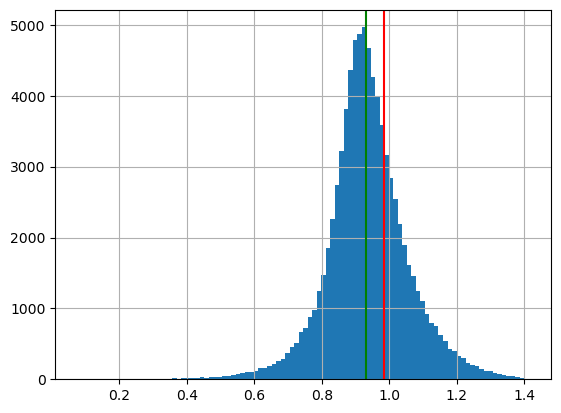

In [147]:
plt.hist(W, bins=100)
plt.grid()
plt.axvline(0.983, c="r")
plt.axvline(14.895082 / 16, c="g")

In [ ]:

def spin_vector(tau4m, nu4m, nucleon4m, int_type: str):
    # WARNING: do not use this function, as it is incorrect
    # TODO remove this or update the code if the other function does not work
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    Q2 = -q**2

    x = Q2 / (2*p.dot(q)) # Björken scaling variable

    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    else:
        raise NotImplementedError("Only qel implemented")
    
    F = (
        (2*W1 + mtau**2 / M**2 * W4) * (Etau - ptau * costheta)
        + W2 * (Etau + ptau * costheta)
        + W3 / M * (Enu * Etau + ptau**2 - (Enu + Etau) * ptau * costheta)
        + mtau**2 / M * W5
    )

    return (
        # sx component, in the tau-nu plane
        -mtau*np.sin(theta)/2 *
        (2*W1 - W2 + Enu / M * W3 - mtau**2/M**2 * W4 + Etau/M * W5)
        / F,
        # sz component
        -1/2 * (
            (2*W1 - mtau**2 / M**2 * W4) * (ptau - Etau * costheta)
            + W2 * (ptau + Etau * costheta)
            + W3 / M * ((Enu + Etau) * ptau - (Enu * Etau + ptau**2) * costheta)
            - mtau**2 / M * W5 * costheta
        ) / F
    )